In [218]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

sheet_id = "1gWaV7dbwImFO6NrfTO08QmZGZIdHBsOdyweaR3BJbYY"
sheet_name = "Datos%20Prediccion%20USD%20Blue"  # <- espacios reemplazados
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

In [219]:
#  Parsear fechas
fechas = ['FECHA_USD', 'FECHA_IPC', 'FECHA_RP', 'FECHA_RESERVAS', 'FECHA_M2', 'FECHA_BADLAR', 'FECHA_TC', 'FECHA_MEP']
for col in fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
# Función para corregir múltiples puntos, dejando solo el último como decimal
def fix_number_format(s):
    if pd.isna(s):
        return s
    s = str(s)
    s = s.replace(',', '.')  # reemplazo coma por punto
    if s.count('.') > 1:
        parts = s.split('.')
        decimal_part = parts[-1]
        integer_part = ''.join(parts[:-1])
        s = integer_part + '.' + decimal_part
    return s
#  Convertir strings numéricos con coma y puntos mal puestos a float
variables = ['USD_VENTA', 'IPC', 'RP', 'RESERVAS', 'M2', 'BADLAR', 'TC', 'MEP']
for col in variables:
    df[col] = df[col].apply(fix_number_format)
    df[col] = pd.to_numeric(df[col], errors='coerce')
#  Función para consolidar por mes con el último valor disponible
def consolidar_mensual(fecha_col, valor_col):
    temp = df[[fecha_col, valor_col]].dropna()
    temp['MES'] = temp[fecha_col].dt.to_period('M')
    mensual = temp.sort_values(fecha_col).groupby('MES').last().reset_index()
    mensual = mensual[['MES', valor_col]]
    return mensual
#  Consolidar cada serie incluyendo MEP
usd = consolidar_mensual('FECHA_USD', 'USD_VENTA')
ipc = consolidar_mensual('FECHA_IPC', 'IPC')
rp = consolidar_mensual('FECHA_RP', 'RP')
reservas = consolidar_mensual('FECHA_RESERVAS', 'RESERVAS')
m2 = consolidar_mensual('FECHA_M2', 'M2')
badlar = consolidar_mensual('FECHA_BADLAR', 'BADLAR')
tc = consolidar_mensual('FECHA_TC', 'TC')
mep = consolidar_mensual('FECHA_MEP', 'MEP')  # <-- nuevo
#  Unir todos los DataFrames
dfs = [usd, ipc, rp, reservas, m2, badlar, tc, mep]
df_final = reduce(lambda left, right: pd.merge(left, right, on='MES', how='outer'), dfs)
#  Convertir MES a datetime (último día del mes, por ejemplo)
df_final['MES'] = df_final['MES'].dt.to_timestamp(how='end').dt.normalize()
#  Ordenar y mostrar
df_final = df_final.sort_values('MES').reset_index(drop=True)
#  Filtrar para eliminar mayo 2025
df_final = df_final[df_final['MES'] != pd.Timestamp('2025-05-31')]
df_final

,MES,USD_VENTA,IPC,RP,RESERVAS,M2,BADLAR,TC,MEP
0,2016-12-31,16.87,1.3,455.0,39.31,594615.0,198.75,16.13,NaN
1,2017-01-31,16.64,1.6,469.0,46.89,601273.0,193.75,16.14,NaN
2,2017-02-28,16.28,2.1,466.0,50.61,597878.0,201.88,15.76,NaN
3,2017-03-31,15.98,2.4,452.0,50.52,587046.0,190.63,15.63,NaN
4,2017-04-30,15.99,2.7,415.0,48.22,588131.0,200.00,15.72,NaN
...,...,...,...,...,...,...,...,...,...
96,2024-12-31,1215.00,2.7,635.0,29.64,19988275.0,319.38,1060.28,1170.41
97,2025-01-31,1220.00,2.2,618.0,28.31,20118507.0,293.13,1079.63,1164.79
98,2025-02-28,1225.00,2.4,780.0,28.12,20701648.0,281.88,1093.18,1228.48
99,2025-03-31,1325.00,3.7,816.0,24.99,21185767.0,301.88,1103.73,1313.97


In [220]:
#  Seleccionamos variables predictoras y variable dependiente (sin 'MES')
X = df_final[['IPC', 'RP', 'RESERVAS', 'M2', 'BADLAR', 'TC', 'MEP']]
y = df_final['USD_VENTA']
#  Convertir a numérico (por si acaso) y limpiar NaNs
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
data = pd.concat([y, X], axis=1).dropna()
y = data['USD_VENTA']
X = data.drop(columns=['USD_VENTA'])
#  Agregar constante para intercepto
X = sm.add_constant(X)
#  Ajustar modelo OLS
modelo = sm.OLS(y, X).fit()
#  Mostrar resumen del modelo
print(modelo.summary())
#  Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nFactor de Inflación de la Varianza (VIF):")
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:              USD_VENTA   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5912.
Date:                Thu, 29 May 2025   Prob (F-statistic):           1.69e-75
Time:                        02:52:23   Log-Likelihood:                -259.87
No. Observations:                  62   AIC:                             535.7
Df Residuals:                      54   BIC:                             552.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.9399     34.623      1.500      0.1

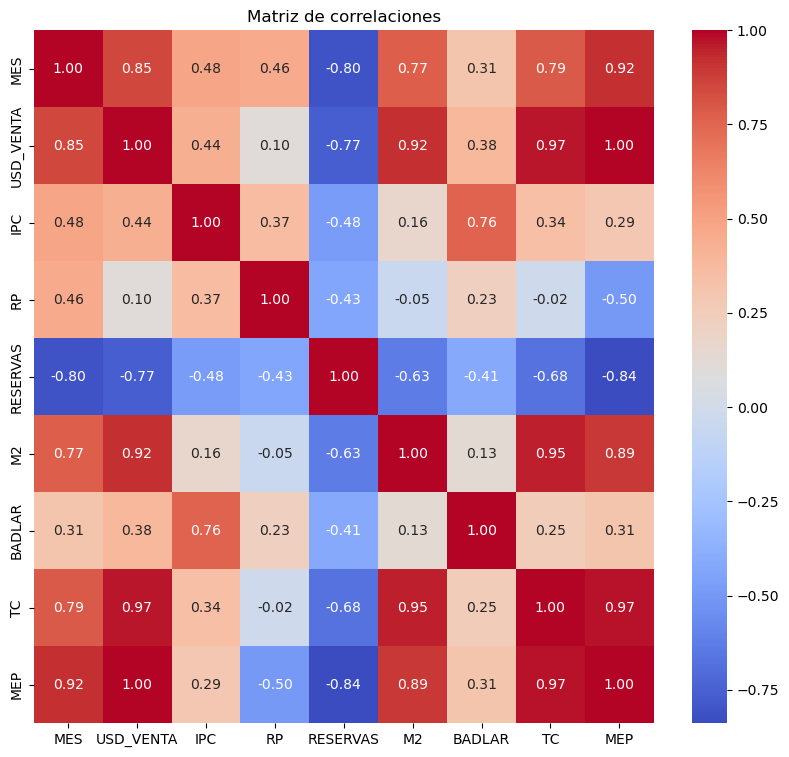

In [221]:
# Mapa de calor de correlación
plt.figure(figsize=(10, 9))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

In [222]:
X = df_final[['IPC', 'RESERVAS', 'M2', 'BADLAR']].apply(pd.to_numeric, errors='coerce') # Sin RP por No Significancia. Sin TC y MEP por Multicolinealidad
y = pd.to_numeric(df_final['USD_VENTA'], errors='coerce')
data = pd.concat([y, X], axis=1).dropna()
y = data['USD_VENTA']
X = data.drop(columns=['USD_VENTA'])
X = sm.add_constant(X)
modelo = sm.OLS(y, X).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              USD_VENTA   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     397.0
Date:                Thu, 29 May 2025   Prob (F-statistic):           8.96e-59
Time:                        02:52:24   Log-Likelihood:                -609.87
No. Observations:                 101   AIC:                             1230.
Df Residuals:                      96   BIC:                             1243.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        226.3391     72.618      3.117      0.0

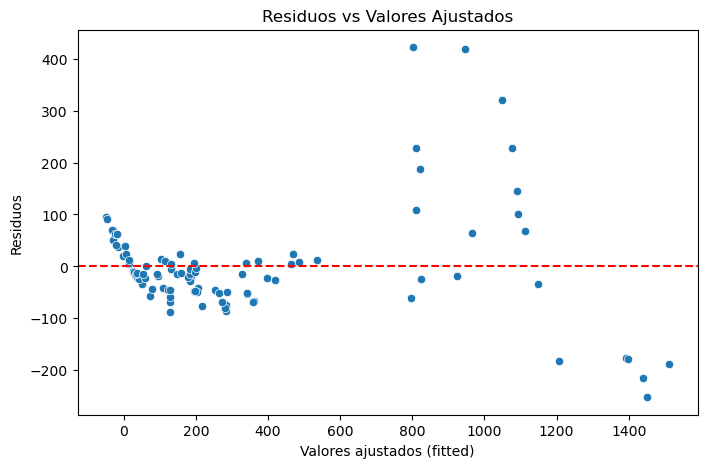

In [223]:
# Valores predichos y residuos
fitted_vals = modelo.fittedvalues
residuals = modelo.resid

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Valores ajustados (fitted)')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')
plt.show()

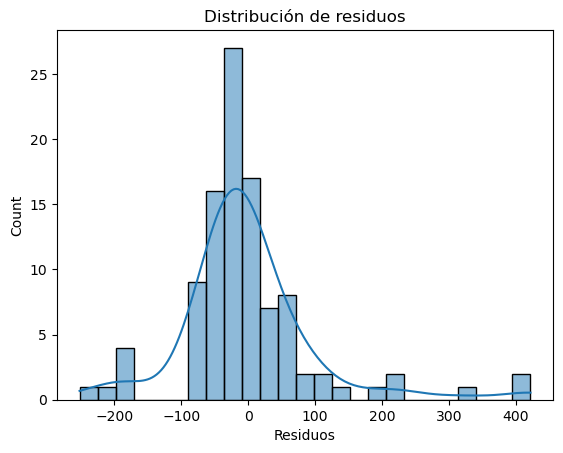

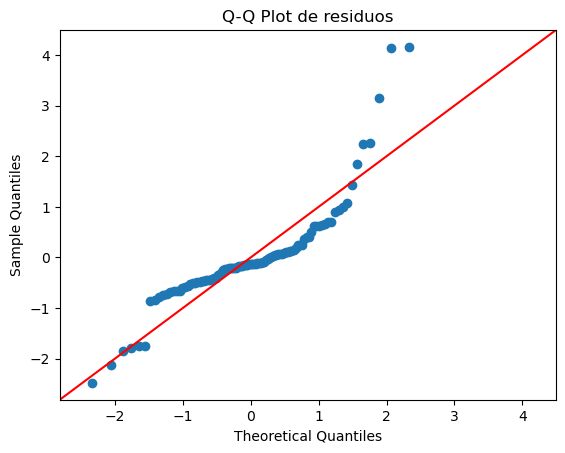

In [224]:
# Histograma
sns.histplot(residuals, kde=True)
plt.title('Distribución de residuos')
plt.xlabel('Residuos')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot de residuos')
plt.show()

MAE: 26.90
RMSE: 34.47
Predicción USD_VENTA siguiente periodo: 1166.33


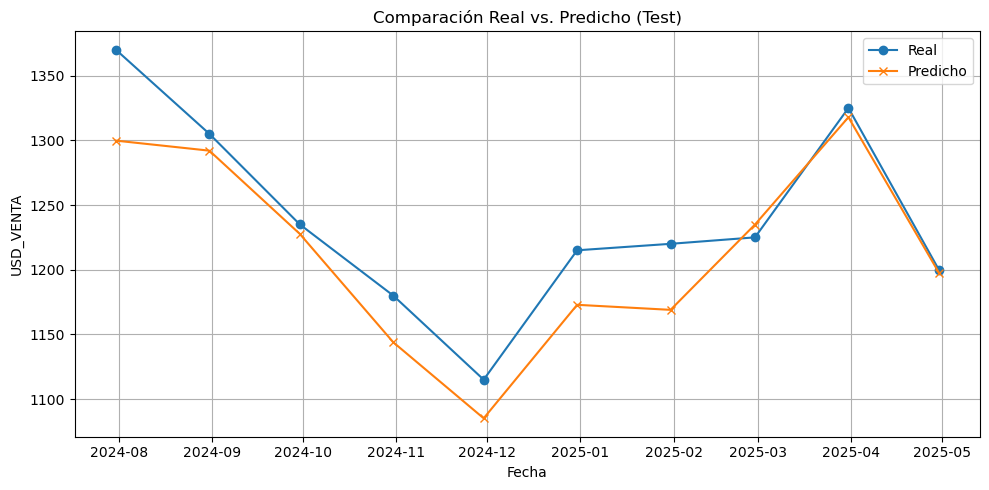

In [225]:
# 1. Convertir MES a datetime e indexar
df_final['MES'] = pd.to_datetime(df_final['MES'])
df_final = df_final.sort_values('MES').reset_index(drop=True)
df_final.set_index('MES', inplace=True)

# 2. Crear solo los lags necesarios
df_final['RESERVAS_lag1'] = df_final['RESERVAS'].shift(1)
df_final['BADLAR_lag1'] = df_final['BADLAR'].shift(1)
df_final['M2_lag1'] = df_final['M2'].shift(1)

# 3. Filtrar desde marzo 2020 (inicio MEP)
df_final = df_final[df_final.index >= '2020-03-01']

# 4. Eliminar NaNs por los lags
df_model = df_final.dropna()

# 5. Definir variables
y = df_model['USD_VENTA']
X = df_model[['IPC', 'RESERVAS_lag1', 'BADLAR_lag1', 'RP', 'MEP']]
X = sm.add_constant(X)

# 6. Train/Test Split (85% train)
train_size = int(len(df_model) * 0.85)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 7. Ajustar modelo
model = sm.OLS(y_train, X_train).fit()

# 8. Predicción
y_pred = model.predict(X_test)

# 9. Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

# 10. Predicción próximo período
last_row = df_final.iloc[-1]
next_input = pd.DataFrame({
    'const': 1,
    'IPC': [last_row['IPC']],
    'RESERVAS_lag1': [last_row['RESERVAS']],
    'BADLAR_lag1': [last_row['BADLAR']],
    'RP': [last_row['RP']],
    'MEP': [last_row['MEP']],
})
next_pred = model.predict(next_input)[0]
print(f'Predicción USD_VENTA siguiente periodo: {next_pred:.2f}')

# 11. Gráfico
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Real', marker='o')
plt.plot(y_test.index, y_pred, label='Predicho', marker='x')
plt.title('Comparación Real vs. Predicho (Test)')
plt.xlabel('Fecha')
plt.ylabel('USD_VENTA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [226]:
print("Ultimos Valores")
print(last_row[['IPC', 'RESERVAS', 'BADLAR', 'M2', 'RP', 'MEP']])

Ultimos Valores
IPC                2.80
RESERVAS          38.93
BADLAR           330.00
M2          21692977.00
RP               726.00
MEP             1183.37
Name: 2025-04-30 00:00:00, dtype: float64


   test_size  train_size           MAE          RMSE
0       0.10        0.90     21.281743     22.931591
1       0.15        0.85     26.898495     34.472660
2       0.20        0.80     28.796526     36.808656
3       0.25        0.75     58.767916     62.722359
4       0.30        0.70     67.411278     73.890128
5       0.35        0.65   8494.894264  15029.728723
6       0.40        0.60   6645.967873  12530.168828
7       0.45        0.55   3538.268167   7055.374846
8       0.50        0.50  21929.897145  46963.398902
9       0.55        0.45  24988.501972  55934.126649


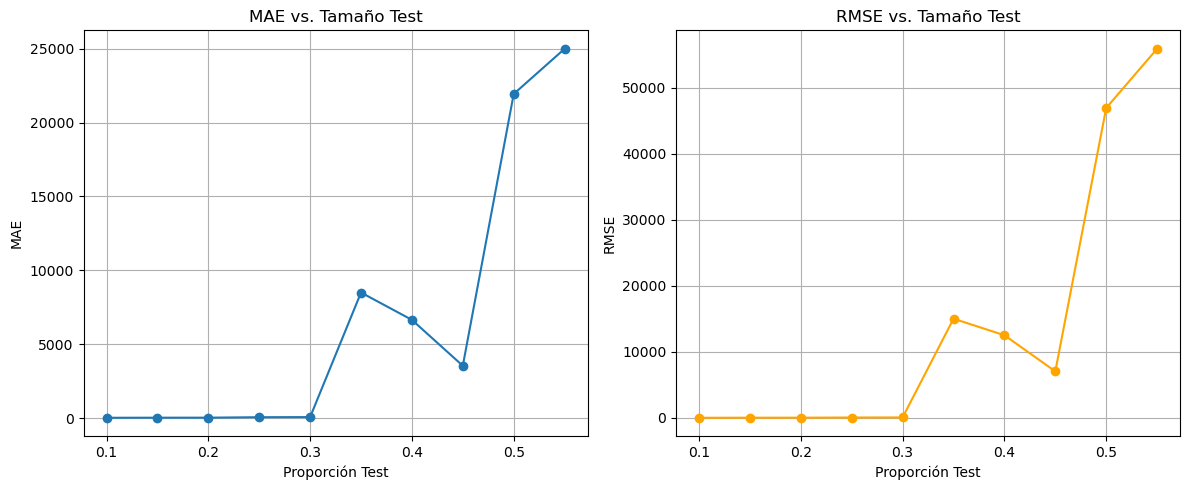

In [227]:
# Lista de tamaños de test (fracciones del dataset)
test_sizes = np.arange(0.1, 0.6, 0.05)  # desde 10% hasta 55% test, paso 5%

results = []

for test_size in test_sizes:
    train_size = int(len(df_model) * (1 - test_size))
    
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results.append({
        'test_size': test_size,
        'train_size': 1 - test_size,
        'MAE': mae,
        'RMSE': rmse
    })

# Convertir a DataFrame para mejor visualización
import pandas as pd
df_results = pd.DataFrame(results)

print(df_results)

# Gráficos para visualizar
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(df_results['test_size'], df_results['MAE'], marker='o')
plt.title('MAE vs. Tamaño Test')
plt.xlabel('Proporción Test')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(df_results['test_size'], df_results['RMSE'], marker='o', color='orange')
plt.title('RMSE vs. Tamaño Test')
plt.xlabel('Proporción Test')
plt.ylabel('RMSE')
plt.grid(True)

plt.tight_layout()
plt.show()

In [269]:
pred_conf = model.get_prediction(next_input)
conf_int = pred_conf.conf_int(alpha=0.90)  # 10% de confianza

lower = conf_int[0][0]
upper = conf_int[0][1]

print(f'Predicción USD_VENTA próximo mes: {next_pred:.2f}')
print(f'Intervalo 5%: ({lower:.2f}, {upper:.2f})')

if lower > last_row['USD_VENTA']:
    print('📈 Probable suba del dólar paralelo.')
elif upper < last_row['USD_VENTA']:
    print('📉 Probable baja del dólar paralelo.')
else:
    print('⏸️ El movimiento no es estadísticamente significativo.')

Predicción USD_VENTA próximo mes: 1166.33
Intervalo 5%: (1163.54, 1184.54)
📉 Probable baja del dólar paralelo.


In [271]:
def tasa_crecimiento_mensual_serie(serie, meses=12):
    """
    Calcula tasa de crecimiento mensual promedio basada en los últimos 'meses' meses.
    """
    serie_reciente = serie[-meses:]
    # crecimiento relativo total
    crecimiento_total = serie_reciente.iloc[-1] / serie_reciente.iloc[0] - 1
    # tasa mensual promedio (asumiendo crecimiento compuesto)
    tasa_mensual = (1 + crecimiento_total) ** (1 / (meses - 1)) - 1
    return tasa_mensual

In [273]:
def proyectar_dolar_tendencia_real(model, df_final, meses=3, alpha=0.10, periodo_tendencia=12):
    last_row = df_final.iloc[-1].copy()
    # Calcular tasas de crecimiento mensual para cada variable relevante
    tasas = {}
    for var in ['IPC', 'RESERVAS', 'BADLAR', 'RP', 'MEP']:
        tasas[var] = tasa_crecimiento_mensual_serie(df_final[var], meses=periodo_tendencia)
    actual_usd = last_row['USD_VENTA']
    predicciones = []
    for i in range(meses):
        # Actualizar variables según la tasa mensual calculada
        for var in tasas:
            last_row[var] = last_row[var] * (1 + tasas[var])
        input_i = pd.DataFrame({
            'const': 1,
            'IPC': [last_row['IPC']],
            'RESERVAS_lag1': [last_row['RESERVAS']],
            'BADLAR_lag1': [last_row['BADLAR']],
            'RP': [last_row['RP']],
            'MEP': [last_row['MEP']],
        })
        pred_i = model.get_prediction(input_i)
        pred_val = pred_i.predicted_mean[0]
        conf_int = pred_i.conf_int(alpha=alpha)
        lower, upper = conf_int[0]
        predicciones.append({
            'Mes': f'+{i+1}',
            'USD_Predicho': pred_val,
            'IC_Bajo': lower,
            'IC_Alto': upper,
            'Delta': pred_val - actual_usd,
            'Tendencia': '📈 Sube' if lower > actual_usd else ('📉 Baja' if upper < actual_usd else '⏸️ Incierto')
        })
        last_row['USD_VENTA'] = pred_val
        actual_usd = pred_val
    df_pred = pd.DataFrame(predicciones)
    # Agregar el valor actual como primer fila del DataFrame
    valor_actual = df_final['USD_VENTA'].iloc[-1]
    df_actual = pd.DataFrame([{
        'Mes': 'Actual',
        'USD_Predicho': valor_actual,
        'IC_Bajo': None,
        'IC_Alto': None,
        'Delta': 0,
        'Tendencia': '🔴 Actual'
    }])
    df_pred = pd.concat([df_actual, df_pred], ignore_index=True)
    # Mostrar tabla
    print(df_pred)
    # Gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(df_pred['Mes'], df_pred['USD_Predicho'], label='Predicción', marker='o')
    # Crear listas extendidas con el valor actual al inicio del IC
    meses_ic = df_pred['Mes']
    ic_bajo_ext = [valor_actual] + df_pred['IC_Bajo'][1:].tolist()
    ic_alto_ext = [valor_actual] + df_pred['IC_Alto'][1:].tolist()
    plt.fill_between(meses_ic, ic_bajo_ext, ic_alto_ext, color='gray', alpha=0.3, label='IC 95%')
    plt.plot('Actual', valor_actual, 's', color='red', label='Valor actual')  # marcador cuadrado rojo
    plt.title('Proyección del dólar Paralelo (USD_VENTA) - con tendencia real histórica')
    plt.xlabel('Mes')
    plt.ylabel('USD_VENTA proyectado')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\santi\AppData\Local\Temp\ipykernel_45316\4259113871.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pred = pd.concat([df_actual, df_pred], ignore_index=True)


      Mes  USD_Predicho      IC_Bajo      IC_Alto      Delta Tendencia
0  Actual   1200.000000          NaN          NaN   0.000000  🔴 Actual
1      +1   1149.152142  1139.099656  1159.204628 -50.847858    📉 Baja
2      +2   1124.292517  1114.600369  1133.984666 -24.859625    📉 Baja
3      +3   1099.407925  1089.918288  1108.897561 -24.884593    📉 Baja


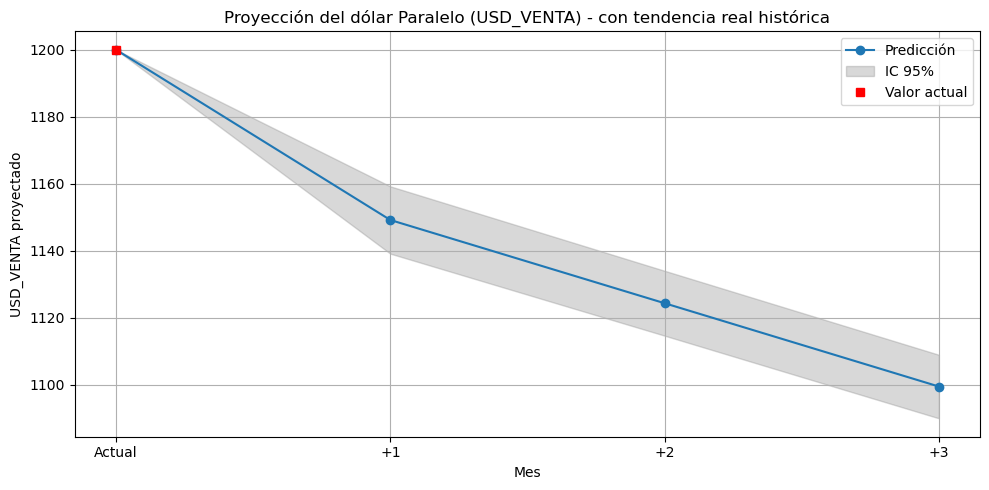

In [275]:
proyectar_dolar_tendencia_real(model, df_final, meses=3, alpha=0.90, periodo_tendencia=3)

In [283]:
# Guardar el DataFrame final como archivo Excel
ruta_salida = r"C:\Users\santi\Downloads\df_Pred_USD_Blue.xlsx"  # ¡IMPORTANTE! Se utilizará para levantar Datos de Power BI
df_final.to_excel(ruta_salida, index=False)